In [44]:
# import packages
import copy
import os
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

from torchvision import datasets
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import save_image

import torch
import torch.optim as optim
import torch.nn as nn
from syft.federated.floptimizer import Optims

import syft as sy
from syft.frameworks.torch.fl import utils
hook = sy.TorchHook(torch)

import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [45]:
NUM_CLIENTS = 2
BATCH_SIZE = 32
LEARNING_RATE = 1e-3

In [46]:
# utility functions
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

def make_dir():
    image_dir = 'FashionMNIST_Images'
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)

def save_decoded_image(img, epoch):
    img = img.view(img.size(0), 1, 28, 28)
    save_image(img, './FashionMNIST_Images/linear_ae_image{}.png'.format(epoch))

def get_averaged_weights(model_dict):
    with torch.no_grad():
        models = [model_dict[key].get() for key in model_dict]
        result_state_dict = models[0].state_dict()
        layer_keys = result_state_dict.keys()
        for key in layer_keys:
            all_weights = [model.state_dict()[key] for model in models]
            result_state_dict[key] = torch.mean(torch.stack(all_weights), dim=0)
        return result_state_dict

In [47]:
class OneLayerAutoencoder(nn.Module):
    def __init__(self):
        super(OneLayerAutoencoder, self).__init__()
        self.enc = nn.Linear(in_features=784, out_features=128)
        self.dec = nn.Linear(in_features=128, out_features=784)

    def forward(self, x):
        x = F.relu(self.enc(x))
        x = F.relu(self.dec(x))
        return x


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # encoder
        self.enc1 = nn.Linear(in_features=784, out_features=256)
        self.enc2 = nn.Linear(in_features=256, out_features=128)
        self.enc3 = nn.Linear(in_features=128, out_features=64)
        self.enc4 = nn.Linear(in_features=64, out_features=32)
        self.enc5 = nn.Linear(in_features=32, out_features=16)
        # decoder
        self.dec1 = nn.Linear(in_features=16, out_features=32)
        self.dec2 = nn.Linear(in_features=32, out_features=64)
        self.dec3 = nn.Linear(in_features=64, out_features=128)
        self.dec4 = nn.Linear(in_features=128, out_features=256)
        self.dec5 = nn.Linear(in_features=256, out_features=784)
    def forward(self, x):
        x = F.relu(self.enc1(x))
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        x = F.relu(self.enc5(x))
        x = F.relu(self.dec1(x))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        x = F.relu(self.dec5(x))
        return x

ae = OneLayerAutoencoder()

In [48]:
def train(model, data, optimizer, criterion):
    # get the inputs; data is a list of [inputs, labels]
    model.train()
    inputs, labels = data

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    return loss


def send_model_to_workers(model, workers):
    return {worker: model.copy().send(worker) for worker in workers}


In [49]:
workers = [sy.VirtualWorker(hook, id="Worker {}".format(i)) for i in range(NUM_CLIENTS)]

federated_data_loader = sy.FederatedDataLoader( # <-- this is now a FederatedDataLoader
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])).federate(workers),
    batch_size=BATCH_SIZE, shuffle=True, iter_per_worker=True)

In [50]:
opt = optim.Adam(ae.parameters(), lr=LEARNING_RATE)
pointers_to_nets = send_model_to_workers(ae, workers)
optims = Optims([w.id for w in workers], opt)
criterion = nn.MSELoss()

In [51]:

COMMUNICATION_ROUNDS = 10
LOCAL_EPOCHS = 1

losses = []

for communication_round in range(COMMUNICATION_ROUNDS):
    print("COMMUNICATION ROUND {}".format(communication_round))
    for local_epoch in range(LOCAL_EPOCHS):
        print("LOCAL EPOCH {}".format(local_epoch))
        for batch_idx, worker_dict in enumerate(federated_data_loader):
            if batch_idx > 50:
                break
            running_loss = 0.0
            for worker in worker_dict:
                remote_data, target = worker_dict[worker]
                remote_data = remote_data.view(remote_data.shape[0], remote_data.shape[1]*remote_data.shape[2]*remote_data.shape[3])
                remote_net = pointers_to_nets[worker]
                optimizer = optims.get_optim(worker=remote_data.location.id)
                batch_loss = train(remote_net, (remote_data, remote_data), optimizer, criterion)
                running_loss += batch_loss.get().item()
            if batch_idx % 100 == 1:
                print(running_loss / (100 * len(workers)))
                losses.append(running_loss / (100 * len(workers)))
    new_state_dict = get_averaged_weights(pointers_to_nets)
    ae.load_state_dict(new_state_dict)
    pointers_to_nets = send_model_to_workers(ae, workers)

COMMUNICATION ROUND 0
LOCAL EPOCH 0
0.010120857656002045
COMMUNICATION ROUND 1
LOCAL EPOCH 0
0.009983119666576385
COMMUNICATION ROUND 2
LOCAL EPOCH 0
0.010360904932022096
COMMUNICATION ROUND 3
LOCAL EPOCH 0
0.010431747436523437
COMMUNICATION ROUND 4
LOCAL EPOCH 0
0.01037764310836792
COMMUNICATION ROUND 5
LOCAL EPOCH 0
0.010259181261062622
COMMUNICATION ROUND 6
LOCAL EPOCH 0
0.010508235692977905
COMMUNICATION ROUND 7
LOCAL EPOCH 0
0.009950703978538512
COMMUNICATION ROUND 8
LOCAL EPOCH 0
0.010028605461120605
COMMUNICATION ROUND 9
LOCAL EPOCH 0
0.009807091057300567


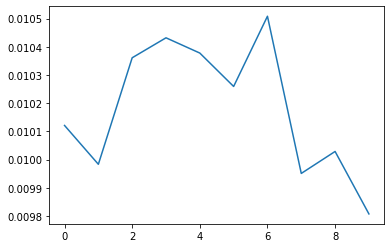

In [52]:
losses
plt.plot(range(len(losses)), losses)
plt.show()